# Cryptocurrency Analysis: Latent Space Dependence
### Ali Habibnia and Matt Harrington

---

**Goals**:
1. Grab all relevant coins (defined by subsets in `subsets.py`, default = `top_50`)
1. Fit benchmark latent variable models 
    1. AR(1)
    2. SARIMA
1. Grenerate Latent Features with Encoding Methods
    1. Vanilla AE
    2. Variational AE
    3. Transformer (?)
1. Pass latent features to predictive models
    1. OLS
    2. RNN
    3. LSTM
    4. Forecasting Transformer
---


## Plumbing

In [1]:
import sys
import os

import importlib
is_colab = importlib.util.find_spec("google")
found = is_colab is not None

import_path = ''
if found:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)
    import_path += '/content/gdrive/My Drive/Thesis/pairs/'

else:
    import_path += 'pairs/'

print(import_path)

pairs/


In [2]:
from subsets import *
from coin_helpers import load_coins, simplify
coins, returns = load_coins(import_path, top_50)

Log-Returns Head:                           BTC       ETH  BCH  BNB  LINK  DOT  ADA  LTC  EOS  \
open_time                                                                     
2017-08-17 04:01:00  0.000000  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:02:00  0.004467 -0.003759  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:03:00 -0.004467  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   

                     XMR  ...  UMA  ONT  YFI  SNX  FTT  BTT  ALGO  DGB  DOGE  \
open_time                 ...                                                  
2017-08-17 04:01:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:02:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:03:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   

                     REN  
open_time                 
2017-08-17 04:01:00  NaN  
2017-08-17 04:02:00  NaN  
2017-08-17 04:03:00  NaN  

[3 rows x 36 columns]


### Helper functions

In [3]:
# N = number of return periods
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

def multi_get_rolling_samples(ts, lag = 12):
    samples = []
    fifth = round(len(ts.index) / 5)
    for i in range(len(ts.index)):
        if i >= lag:
            if i % fifth == 0:
                print("{} periods done".format(i))
            s = ts.iloc[i-lag: i]
            samples.append(s)

## Setting up import dictionary "coins", returns, and subsets

#### Subsetting

In [4]:
hour_ret = simplify(returns, '1h')
day_ret = simplify(returns, '1D')

In [5]:
n = 365
twoyr, oneyr = [], []
for c in day_ret.columns:
    nulls = day_ret[c].isnull().sum()
    lengs = day_ret[c].shape[0]
    if lengs - nulls > n:
        oneyr.append(c)
        if lengs - nulls > 2*n:
            twoyr.append(c)

nyr = len(oneyr)
nall = len(returns.columns)
p = round(100 * nyr / nall, 2)
print("{0} of {1} ({2}%) have more than {3} days of data".format(nyr, nall, p, n))
print("{0} of {1} ({2}%) have more than {3} days of data".format(len(twoyr), nall, p, 2 * n))

26 of 36 (72.22%) have more than 365 days of data
14 of 36 (72.22%) have more than 730 days of data


---
## Deep Learning Models

###### Code based on [atcold/pytorch-deep-learning](https://github.com/Atcold/pytorch-Deep-Learning) on Github

#### Library imports

In [6]:
# standard 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Pytorch
import torch
import torchvision
from torch import nn
import torch.nn.functional as fs

# Pretty
from IPython import display

#### Dataset creation

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class CryptoReturnsDataset(Dataset):

    def __init__(self, params, train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = torch.tensor(raw.iloc[lag : train_test_thresh].values)
        else:
            self.data = torch.tensor(raw.iloc[train_test_thresh :].values)
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        
    def __getitem__(self, index):
        x = self.data[index : index + self.lag]
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        y = self.data[index + self.lag].reshape(-1)
        return x, y

    def __len__(self):
        return self.n_samples

In [8]:
# crypto_transforms = transforms.Compose([
#     transforms.Resize(lag * len(subset)),
#     transforms.ToTensor()
# ])

######## Dataset Parameters ########
lag = 12
subset = oneyr
n_coins = len(subset)
PARAMS = (returns,      # Returns df
          '1h',         # Resample Frequency
          lag,          # AR Lag
          subset)       # Coin subset


######## Data loader ########
train_dataset = CryptoReturnsDataset(PARAMS, True)
test_dataset = CryptoReturnsDataset(PARAMS, False)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

######## Device ########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---
### Vanilla AutoEncoder
---

In [9]:
# Define standard AE model architecture and reconstruction loss

ae_dim = 30  # for standard AE (under-complete hidden layer)
# ae_dim = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(lag * n_coins, ae_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(ae_dim, lag * n_coins),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Training step

In [10]:
epoch_jump = 30
num_models = 5
models = []
ae_losses = []
criterion = nn.MSELoss()
learning_rate = 1e-3

for mod in range(num_models):
    ######## Model instantiation ########
    model = Autoencoder().to(device)
    models.append(model)

    ######## Configure the optimiser ########  
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
    )

    num_epochs = epoch_jump * (mod + 1)
    training_loss = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            x, _ = data
            x = x.to(device)
            x = x.view(x.size(0), -1)
            
            # =================== forward =====================
            output = model(x)  # feed <x> (for std AE) or <x_bad> (for denoising AE)
            loss = criterion(output, x.data)
            
            # =================== backward ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # =================== log ========================
        print(f'model [{mod + 1}], epoch [{epoch + 1}/{num_epochs}], loss: {loss.item():.9f}')
        display.clear_output(wait=True)
        
        # =================== record ========================
        training_loss[epoch] = loss.item()
    ae_losses.append(training_loss)

model [5], epoch [150/150], loss: 0.000001546


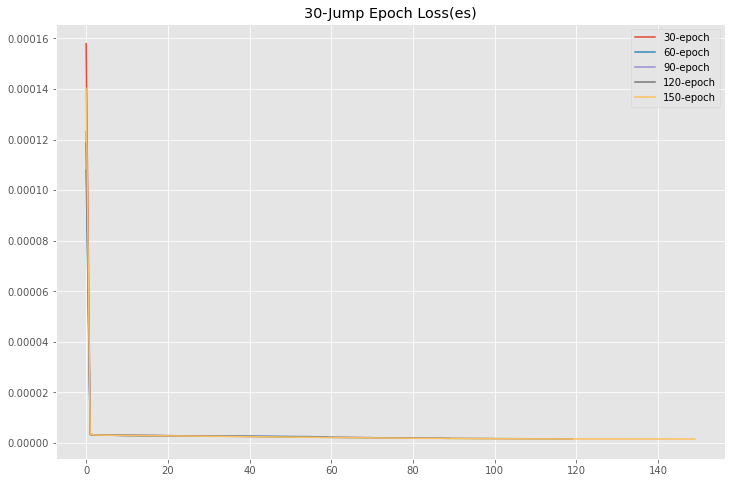

In [11]:
def plot_model_losses(losses):
    fig=plt.figure(figsize=(12,8)) 
    for i, arr in enumerate(losses):
        ne = len(arr)
        plt.plot(arr, label=f'{ne}-epoch')
    plt.title(f"{len(losses[0])}-Jump Epoch Loss(es)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_losses(ae_losses)

#### Testing Steps

In [12]:
test_errors = []
errs = [np.ones(len(test_dataset))] * num_models
mags = np.ones(len(test_dataset))
for mod in range(num_models):
    model = models[mod]
    for i, data in enumerate(test_loader):
        x, _ = data
        x = x.to(device)
        flat_x = x.view(x.size(0), -1)
        output = model(flat_x)
        errs[mod][i] = torch.norm(output - flat_x, dim=1)
        if mod == 0: 
            mags[i] = torch.norm(flat_x, dim=1)


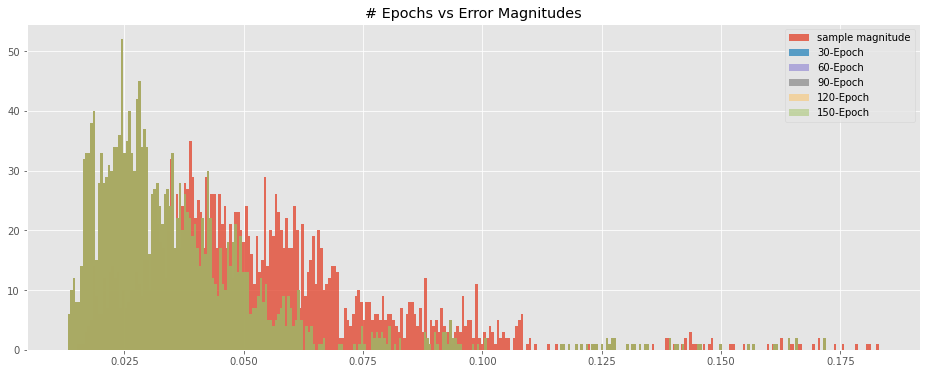

In [13]:
fig = plt.figure(figsize=(16,6))
plt.hist(mags, bins=300, label='sample magnitude', alpha=.8)
for i, err in enumerate(errs):
    plt.hist(err, bins=300, label=f"{(i+1)*epoch_jump}-Epoch", alpha=.8 - (.1 * i))
plt.grid(True)
plt.title("# Epochs vs Error Magnitudes")
plt.legend()
plt.show()

#### Latent AE Dataset

In [14]:
errs = np.array(errs)
errmeans = errs.mean(axis=1)
best_index = np.where(errmeans == min(errmeans))[0][0]
best_ae = models[best_index]

In [15]:
class AELatentDataset(Dataset):

    def __init__(self, params = PARAMS, model = best_ae, train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = torch.tensor(raw.iloc[lag : train_test_thresh].values)
        else:
            self.data = torch.tensor(raw.iloc[train_test_thresh :].values)
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        self.ae = model
        
    def __getitem__(self, index):
        x = self.data[index : index + self.lag]
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        latent_x = torch.tensor(self.ae.encoder(x))
        y = self.data[index + self.lag].reshape(-1)
        return latent_x, y

    def __len__(self):
        return self.n_samples

######## Data loader ########
ae_latent_train_dataset = AELatentDataset(PARAMS, best_ae, train = True)
ae_latent_test_dataset = AELatentDataset(PARAMS, best_ae, train = False)

ae_latent_train_loader = DataLoader(ae_latent_train_dataset, 
                                    batch_size = 128, 
                                    shuffle=False)
ae_latent_test_loader = DataLoader(ae_latent_test_dataset,
                                   batch_size = 1,
                                   shuffle=False)

---
### Variational AutoEncoder
---

In [16]:
# Defining the model

d = 20
in_dim = lag * n_coins

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, in_dim),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, in_dim)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

In [17]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, in_dim), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [18]:
# Training and testing the VAE
import copy
codes = dict(μ=list(), logσ2=list(), y=list())
epoch_jump = 4
num_models = 5
models = []
train_losses = []
test_losses = []
ref_model = VAE()

# Multi-model loop
for mod in range(num_models):

    ######## Model instantiation ########
    model = copy.deepcopy(ref_model).to(device)
    models.append(model)

    num_epochs = epoch_jump * (mod + 1)
    training_loss = np.zeros(num_epochs)
    testing_loss = np.zeros(num_epochs + 1)
   
    for epoch in range(0, num_epochs + 1):
    
        # Training
        if epoch > 0:  # test untrained net first
            model.train()
            train_loss = 0
            for x, _ in train_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                loss = loss_function(x_hat, x, mu, logvar)
                train_loss += loss.item()
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
            avg_loss = train_loss / len(train_loader.dataset)
            print(f'====> Model: {mod+1}, Epoch: {epoch}, Average loss: {avg_loss:.4f}')

            training_loss[epoch-1] = avg_loss
    
        # Testing
        means, logvars, labels = list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, y in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                # =====================log=======================
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(y.detach())
        
        # ===================log========================
        codes['μ'].append(torch.cat(means))
        codes['logσ2'].append(torch.cat(logvars))
        codes['y'].append(torch.cat(labels))
        test_loss /= len(test_loader.dataset)
        print(f'====> Test set loss: {test_loss:.4f}')
        testing_loss[epoch] = test_loss
        display.clear_output(wait=True)
    
    train_losses.append(training_loss)
    test_losses.append(testing_loss)

====> Model: 5, Epoch: 20, Average loss: 216.6390
====> Test set loss: 215.8877


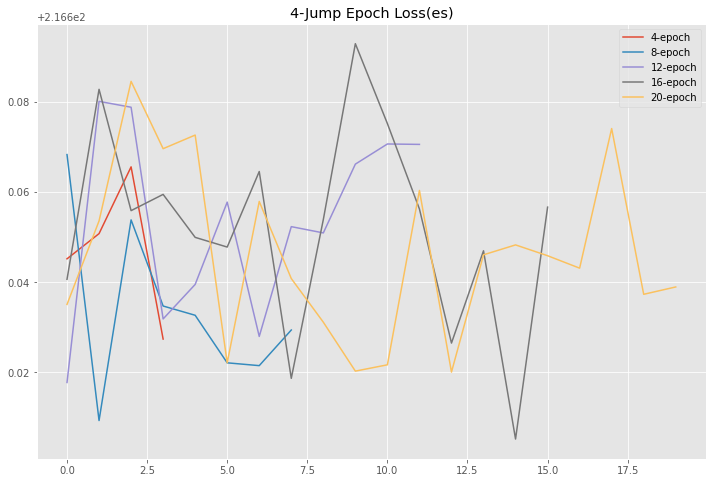

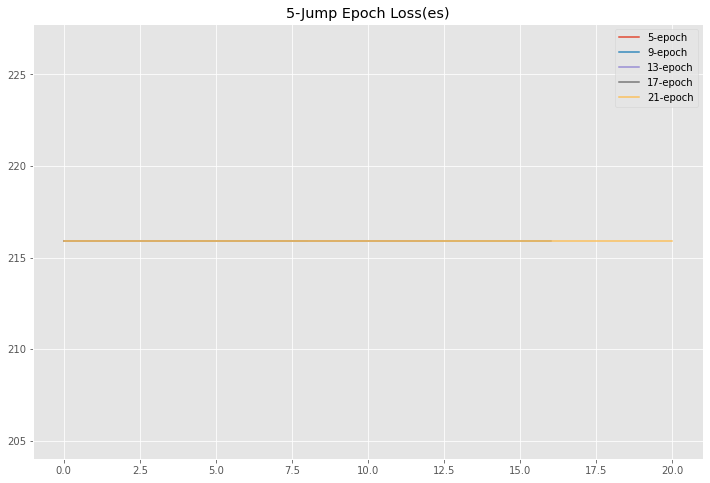

In [19]:
plot_model_losses(train_losses)
plot_model_losses(test_losses)

#### VAE Latent Dataset

In [20]:
errs = np.array([np.mean(x) for x in train_losses])
best_index = np.where(errs == min(errs))[0][0]
best_vae = models[best_index]

In [21]:
class VAELatentDataset(Dataset):

    def __init__(self, params = PARAMS, model = best_vae, train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = torch.tensor(raw.iloc[lag : train_test_thresh].values)
        else:
            self.data = torch.tensor(raw.iloc[train_test_thresh :].values)
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        self.vae = model
        self.vae.eval()
        
    def __getitem__(self, index):
        x = self.data[index : index + self.lag]
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        _, mu, logvar = self.vae.forward(x)
        latent_x = self.vae.reparameterise(x)
        y = self.data[index + self.lag].reshape(-1)
        return latent_x, y

    def __len__(self):
        return self.n_samples

######## Data loader ########
vae_latent_train_dataset = VAELatentDataset(PARAMS, best_vae, train = True)
vae_latent_test_dataset = VAELatentDataset(PARAMS, best_vae, train = False)

vae_latent_train_loader = DataLoader(vae_latent_train_dataset, 
                                     batch_size = 128, 
                                     shuffle=False)
vae_latent_test_loader = DataLoader(vae_latent_test_dataset,
                                    batch_size = 1,
                                    shuffle=False)

## Baseline Predictive Models

In [22]:
!pip install statsmodels
import statsmodels as sm




## Predictive Models

In [23]:
######## AE Latent Dataset ########
ae_latent_train_dataset, ae_latent_test_dataset
ae_latent_train_loader, ae_latent_test_loader

######## VAE Latent Dataset ########
vae_latent_train_dataset, vae_latent_test_dataset
vae_latent_train_loader, vae_latent_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1223bff40>,
 <torch.utils.data.dataloader.DataLoader at 0x11cffcf10>)

In [24]:
# Leverage helper function code to create rolling multivariate AR windows
#   to serve as input for the AE models

In [25]:
# grab / organize the latent outputs from the 
#   encoding models & prep for prediction

In [26]:
import warnings
# warnings.filterwarnings("UserWarning")

# LSTM 
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for data, target in train_data_gen:

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        # data, target = train_data_gen[batch_idx]
        # data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        data, target = torch.tensor(data).float().to(device), torch.tensor(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item() 

def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for data, target in test_data_gen:
            data, target = torch.tensor(data).float().to(device), torch.tensor(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model


<ipython-input-15-7c51e5e7f4a4>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_x = torch.tensor(self.ae.encoder(x))
<ipython-input-26-5a465d899496>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = torch.tensor(data).float().to(device), torch.tensor(target).long().to(device)
<ipython-input-26-5a465d899496>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = torch.tensor(data).float().to(device), torch.tensor(target).long().to(device)


[Epoch 1/4] loss: 2.7008, acc: 16.93% - test_loss: 2.6902, test_acc: 100.00%
[Epoch 2/4] loss: 2.0322, acc: 99.47% - test_loss: 2.0229, test_acc: 100.00%
[Epoch 3/4] loss: 1.4528, acc: 99.47% - test_loss: 1.4464, test_acc: 100.00%
[Epoch 4/4] loss: 1.0152, acc: 99.47% - test_loss: 1.0112, test_acc: 100.00%


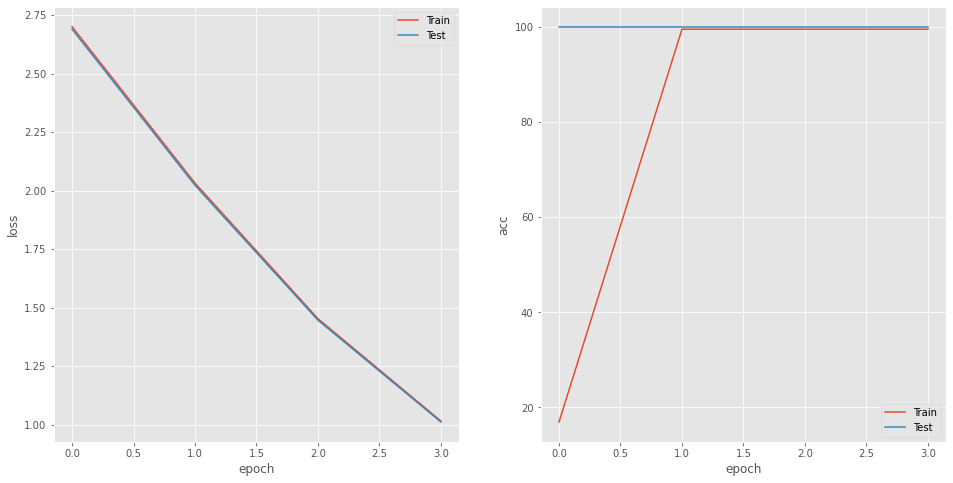

In [27]:
# Setup the RNN and training settings
input_size  = ae_dim
hidden_size = 4
output_size = n_coins
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 4

# Train the model
model = train_and_test(model, ae_latent_train_loader, 
                       ae_latent_test_loader, criterion, 
                       optimizer, max_epochs)

In [28]:
# LSTM - predicting latent representation with AR latent predictor

## Transformer Model

##### Multi-head Attention

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        
        return H, A

##### Convolutional Layer

In [30]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

##### Transformer Encoder

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2

Blocks of N Encoder Layers + Positional encoding + Input embedding

Self attention by itself does not have any recurrence or convolutions so to make it sensitive to position we must provide additional positional encodings. These are calculated as follows:

In [32]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [33]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, p)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

##### Transformer Classifier

In [34]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)
        
        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        return x

In [35]:
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                         conv_hidden_dim=128, input_vocab_size=50002, num_answers=2)
model.to(device)

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
t_total = len(train_loader) * epochs

In [ ]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    for batch in data_iterator:
        x = batch.text.to(device)
        y = batch.label.to(device)
                
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()

    print(f"Eval accuracy: {acc / nb_batches}")

In [ ]:
# Transformer predictor?